<a href="https://colab.research.google.com/github/choiminji-020102/Image-processing_Deep-learning/blob/main/06_convlayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional layer 구현 실습

질감 이미지 데이터셋인 Describable Textures Dataset (DTD)를 이용해 간단한 CNN 구현 실습을 진행한다. 아래는 Pytorch를 이용하여 데이터를 다운받고 샘플을 취하는 코드이다. (참고: 약간의 시간이 소요됨)


In [ ]:
# 파이토치 설치 확인
!pip install torch torchvision

# Describable Textures Dataset (DTD) 데이터셋
import torch
from torchvision import datasets, transforms

dtd_data = datasets.DTD('../data', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (1.0,))
                   ]))


100%|██████████| 625239812/625239812 [00:13<00:00, 44728291.37it/s]


Extracting ../data/dtd/dtd-r1.0.1.tar.gz to ../data/dtd


아래는  DTD 데이터셋에서 가져온 질감 이미지 예시이다. 클래스 0과 클래스 1 이미지의 특징을 자세히 살펴보도록 하자.

0


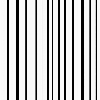

0


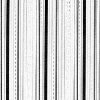

0


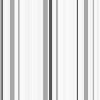

0


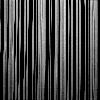

0


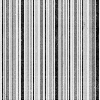

0


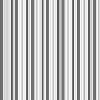

0


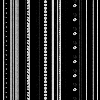

0


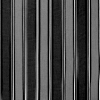

1


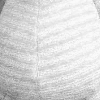

1


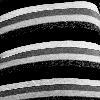

1


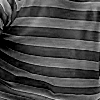

1


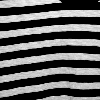

1


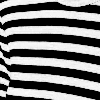

1


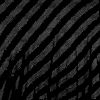

1


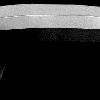

1


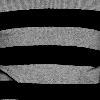

In [ ]:
import numpy as np, cv2
from google.colab.patches import cv2_imshow

# 임의로 골라낸 테스트이미지
# 세로줄 질감 이미지 8장, 가로줄 질감 이미지 8장
im0 = [0, 1, 2, 3, 4, 7, 8, 38]
im1 = [28, 30, 31, 33, 34, 35, 36, 37]

imgs = im0 + im1
targets = [0]*8 + [1]*8  # 레이블정보 (세로질감:0, 가로질감:1)

def getImage(dtd_data, index, im_size=100):
    image = torch.squeeze(dtd_data[index][0]).numpy()*500
    return cv2.resize(image[0,:,:], dsize=(im_size, im_size))

# image list 출력
for x, y in zip(imgs, targets):
    image = getImage(dtd_data, x, im_size = 100)

    print(y)
    cv2_imshow(image)


2D 이미지 컨볼루션 테스트 코드

original image


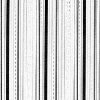

filtered image


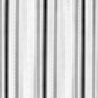

In [ ]:
def Conv2D(image, filter):
    rows, cols = image.shape[:2]
    xcenter, ycenter = filter.shape[1]//2, filter.shape[0]//2   # 마스크 중심 좌표
    fx_shape, fy_shape = filter.shape[1], filter.shape[0]       # 필터 사이즈 (홀수만 가능)
    dst = np.zeros((rows-fy_shape+1, cols-fx_shape+1))  # 결과 저장 행렬

    for i in range(ycenter, rows - ycenter):                    # 입력 행렬 반복 순회
        for j in range(xcenter, cols - xcenter):
            y, x = i - ycenter , j - xcenter
            dst[i-ycenter, j-xcenter] = np.sum(image[y:y+fy_shape, x:x+fx_shape] * filter)
    return dst

image = getImage(dtd_data, 1, im_size = 100)

# 블러링 마스크 원소 지정
filter = [1/9, 1/9, 1/9,
        1/9, 1/9, 1/9,
        1/9, 1/9, 1/9]
filter = np.array(filter, np.float32).reshape(3, 3)

print("original image")
cv2_imshow(image)

print("filtered image")
cv2_imshow(Conv2D(image, filter) )


# 실습 과제 (Conv2D)


**문제 1.** toy_convlayer와 toy_pooling 함수는 간략화된 convoluational layer와 average pooling(평균)을 각각 구현한 함수이다. 최종적인 CNN 출력 사이즈가 7x7이 되도록 convlayer와 pooling 레이어를 쌓으시오.  


(참고사항) Conv layer는 다음과 같은 4가지 hyperparameter를 필요로 한다.

- Number of filters $k$
- The filter size $f$
- the stride $s$
- the zero padding $p$



**문제 2.** 위 convolution layer의 필터를 설정하는 함수 setFilter에 넣는 인자값을 직접 수정하여 결과가 바뀌는 방향을 살펴보시오. 여러분은 convlayer를 최종적으로 통과한 값들의 통계적 특성들이 아래그림처럼 어느정도 선형적으로 분류 가능한(linearly separable) 상태로 만들 수 있는가?

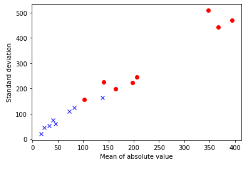





**문제 3.** 본 실습에서는 $k$를 1로만 설정하였고 $k>1$인 경우를 처리하는 코드는 미완성인 상태이다. 만약 convolution layer의 $k$를 2 이상으로 설정하면 아마 코드가 정상적으로 동작하지 않을 것 이다. 코드를 수정해야한다면 toy_convlayer()의 어디를 어떻게 수정해야 할까?

- 테스트 시 레이어는 [Conv - pooling - Conv - pooling]로 구성한다.
- toy_convlayer 생성 시 $k$를 2 이상의 값으로 한다.  
- 코드 수정 계획만 주석으로 설명해 놓아도 됨
- 6주차 강의자료 45page, 47page의 문제를 확실하게 이해한 후 풀이 진행할 것





입력 이미지의 채널 수와 convolution filter 채널 수를 맞춰야 함

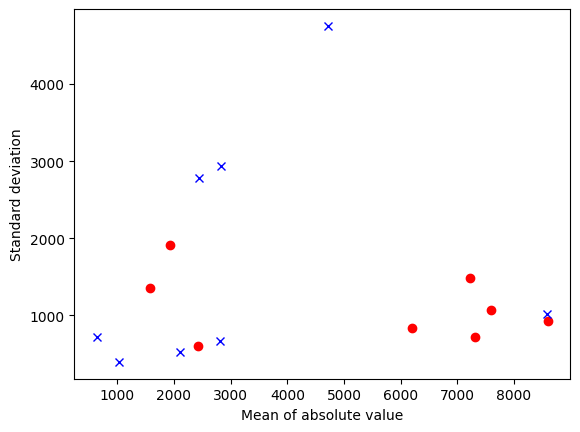

In [ ]:
# forward만 구현한 초간단 convolution layer
class toy_convlayer():
    def __init__(self, in_c=1, f=3, k=2):
        self.f = f        # f: filter size
        self.k = k        # k: number of filters
        self.in_c = in_c
        self.W = np.random.rand(f, f, in_c, k)   # random initialize

    def setFilter(self, W):
        self.W = W

    def forward(self, x):
        # convolution 출력 결과
        result = np.zeros((x.shape[0] - self.f + 1, x.shape[1] - self.f + 1, self.k))

        # k개 filter 별로 convolution 수행 (미구현)
        for k in range(self.k):
          filter = self.W[:,:,:,k]
          result[:, :, k] = self.conv2D(x, filter)

        return result

    def conv2D(self, image, filter):
        rows, cols = image.shape[:2]
        dst = np.zeros((rows, cols), np.float32)                    # 결과 저장 행렬
        xcenter, ycenter = filter.shape[1]//2, filter.shape[0]//2   # 마스크 중심 좌표
        fx_shape, fy_shape = filter.shape[1], filter.shape[0]       # 필터 사이즈 (홀수만 가능)


        for i in range(ycenter, rows - ycenter):                    # 입력 행렬 반복 순회
            for j in range(xcenter, cols - xcenter):
                y, x = i - ycenter , j - xcenter
                # print(image[y:y+fy_shape, x:x+fx_shape].shape)
                dst[i, j] = np.sum(image[y:y+fy_shape, x:x+fx_shape] * filter)
        return dst[xcenter:-xcenter, ycenter:-ycenter]         # 테두리 제거

# forward만 구현한 초간단 pooling layer
class toy_pooling():
    def __init__(self, pooling_size=2):
        self.p = pooling_size

    def forward(self, inputs):
        outputs = np.zeros((inputs.shape[0]//self.p, inputs.shape[1]//self.p, inputs.shape[2]))

        # average pooling pseudo-implementation
        for i in range(inputs.shape[2]):
            outputs[:,:,i] = cv2.resize(inputs[:,:,i], dsize=(0, 0), fx=1/self.p, fy=1/self.p)
        return outputs


########################################################
########## 문제 1. 이곳에 코드를 작성하시오 ############
# 입력 이미지 사이즈가 34x34일 때 출력 사이즈가 7x7가 되도록 레이어를 쌓으시오

# f : 필터 사이즈, k: 필터수
layer1 = toy_convlayer(f=3, k=2)           # 입력 사이즈 34, 출력 사이즈 32

layer2 = toy_pooling(pooling_size = 2)     # 입력 사이즈 32, 출력 사이즈 16

layer3 = toy_convlayer(in_c=2, f=3, k=2)   # 입력 사이즈 16, 출력 사이즈 14

layer4 = toy_pooling(pooling_size = 2)     # 입력 사이즈 14, 출력 사이즈 7

########################################################
########## 문제 2. 이곳에 코드를 작성하시오 ############
# 각 layer의 필터의 원소값을 직접 지정해 보시오
# convlayer class의 sefFilter() 사용
filter1 = [-1, 0, 1,
           -1, 0, 1,
           -1, 0, 1]


# layer1.setFilter(np.array(filter1, np.float32).reshape(3, 3, 1))



# 본 실습에서는 forward 연산 만 수행함
stats1, stats2 = [], []
for img, target in zip(imgs, targets):
    input = getImage(dtd_data, img, im_size = 34)   # (34, 34)
    input = np.expand_dims(input, axis=2)           # (34, 34, 1)
    ########################################################
    ########## 문제 1. 이곳에 코드를 작성하시오 ############
    # layer 1
    output = layer1.forward(input)    # convolution

    # layer 2
    output = layer2.forward(output)   # average pooling

    # layer 3
    output = layer3.forward(output)   # convolution

    # layer 4
    output = layer4.forward(output)   # average pooling

    ########################################################
    # 여기에 선형분류기를 붙여서 학습을 진행할 수 있으며
    # 이 부분은 추후 연습문제로 남겨둔다.
    pass

    # 선형분류기를 붙이는 대신 Conv 레이어를 통과한 값들의
    # 통계적 특성이 어떤 형태로 나타나는지 살펴보자
    stats1.append(np.abs(output).mean()) # 절대값의 평균
    stats2.append(output.std())          # 표준편차
    ########################################################

##################################################################
# 통계적 특성들이 linearly separable한 상태인지 시각적으로 확인
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

plt.plot(stats1[:8], stats2[:8], 'ro')
plt.plot(stats1[8:16], stats2[8:16], 'bx')
plt.plot(stats1[16:24], stats2[16:24], 'g+')
ax.set_xlabel('Mean of absolute value')
ax.set_ylabel('Standard deviation')
plt.show()


## 참고자료(심화) Convlayer의 backpropagation

참고 설명 [링크1](https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c), [링크2](https://medium.com/@2017csm1006/forward-and-backpropagation-in-convolutional-neural-network-4dfa96d7b37e)

∂L/∂F is the convolution between Input X and Loss Gradient from the next layer ∂L/∂Y.

\begin{align}
\frac{\partial L}{\partial F} = \textrm{Convolution}(X , \frac{\partial L}{\partial Y})
\end{align}

∂L/∂X can be represented as ‘full’ convolution between a 180-degree rotated Filter F and loss gradient ∂L/∂Y.

\begin{align}
\frac{\partial L}{\partial X} = \textrm{Full_convolution}(\frac{\partial L}{\partial Y},  \textrm{rotation}(F, 180^{\circ}))
\end{align}


